# Offensive Language Convolutional Neural Network
This Neural network(NN) will detect hate speech among tweets. We used the dataset [Twitter Sentiment Analysis Detecting hatred tweets](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech#train.csv) that contains over 30,000 labeled tweets. Each tweet is labeled as 1 meaning the tweet's contents portray sexist and/or racist remarks or 0 meaning it does not. We mapped each word in the tweet to a unique vector based on the context that it was used with the GoogleNews-vectors-negative300.bin Skipgram model. This model allowed for our neural network to pick up on the context of the word rather than simply memorizing word sequences. 

We trained our data using the 80% 20% rule with a training set of 3,200 unique tweets while the testing sample's batch size was 800. On the testing sample, we achieved an overall accuracy of 95% and a loss value of just 0.16.

## Step 1: Word Classification
Read the data files and separate into two categories: hate_data and good_data then randomly combine the data into one list.

In [1]:
#import all necessary modules
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import nltk
import numpy as np

warnings.filterwarnings(action = 'ignore')

import gensim
from gensim.models import Word2Vec

In [2]:
#read the hate tweets file
sample = open("hateTweets.txt", "r",  encoding = "ISO-8859-1")
s = sample.read()

#replace escape characters with space
f = s.replace("\n", " ")

hate_data = []

#iterate through each sentece in the file
for i in sent_tokenize(f):
    temp = []
    
    #tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    
    hate_data.append(temp)

In [3]:
#read the nice tweets file
sample = open("goodTweets.txt", "r",  encoding = "ISO-8859-1")
s = sample.read()

#replace escape characters with space
f = s.replace("\n", " ")

good_data = []

#iterate through each sentece in the file
for i in sent_tokenize(f):
    temp = []
    
    #tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    
    good_data.append(temp)

In [4]:
#Randomize the hate and nice data into one list of size 4000
import random
data = []
label_data = []

#9,000 total
good_data = good_data[0:2400]
hate_data = hate_data[0:1600]

while len(good_data) != 0 and len(hate_data) != 0:
    random_selection = random.randint(0,1)

    if random_selection is 0:
        label_data.append(0)
        data.append(good_data.pop())
    else:
        label_data.append(1)
        data.append(hate_data.pop())
        
while len(good_data) != 0:
    label_data.append(0)
    data.append(good_data.pop())
    
while len(hate_data) != 0:
    label_data.append(1)
    data.append(hate_data.pop())

## Step 2: Word Embedding
Change each word in the sentence to a vector of size 100 using Skip Gram architecture to predict the surrounding context of a word and Google's word2vec software.

In [5]:
#Create Skip Gram model by loading in the GoogleNews-vectors-negative300.bin 
#Translates a word into a 300 vector of double values describing relation to other words
model = gensim.models.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True) 

In [6]:
#get the word vectors
word_vectors = model.wv

In [7]:
#create a 100 size text vector for the tweet, pad with 0 if not 100 words
all_tweets = []
for tweet in range(0,4000): 
    tweet_as_100_words = np.zeros(100, dtype = '<U100')
    for word_index in range(len(data[tweet])):
        if word_index < 100:
            np.put(tweet_as_100_words, word_index, data[tweet][word_index])
    tweet_as_100_words[tweet_as_100_words=='']='0'
    all_tweets.append(tweet_as_100_words)
all_tweets = np.asarray(all_tweets)

In [8]:
#append the word vectors so that we have a 100 x 300 numpy array
new_list = []

for tweet in all_tweets:
    word_list = []
    for word in tweet:
        try:
            word_list.append(word_vectors[word])
        except:
            word_list.append(word_vectors['UNK'])
    new_list.append(word_list)
            
new_list = np.asarray(new_list)

## Step 3: Create Neural Network & Visualize Learning Process
The Convolutional Neural Network architecture will predict whether a tweet is racist/sexist or not using the Frameworks Pytorch and Keras. Output will be in the form of a binary string where:

| Not Racist/Sexist | Racist/Sexist |       Result      |
|-------------------|---------------|-------------------|
|         0         |       1       |   Racist/Sexist   |
|         1         |       0       | Not Racist/Sexist |

After fitting the data, the Training Set Accuracy and Loss of the Neural Network is plotted on two separate pyplots.

In [9]:
#Create the Neural Network using Keras and TensorFlow
from torch import nn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GRU, GlobalMaxPooling1D, Flatten
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [10]:
def evaluate_model(trainX, trainY, testX, testY):
    verbose, epochs, batch_size = 0, 100, 4000
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainY.shape[1]
    neural_model = Sequential()

    # Add a 1D convolutional layer to filter feature space to a 100x100 representation
    neural_model.add(Conv1D(filters=100,kernel_size=(4),padding="same",activation='relu',
                           input_shape=(n_timesteps, n_features)))
    neural_model.add(Conv1D(filters=100,kernel_size=(4),padding="same",activation='relu'))
    
    # Dropout rate at 20% of total words. This avoids overfitting by randomly removing 
    # words in sentences and forcing the classification to not only rely on specific words
    neural_model.add(Dropout(0.2))
    
    # Pass into 1D max pooling layer to produce output shape of 25x100 to extract features
    neural_model.add(MaxPooling1D(pool_size=4))
    
    # Make the neural model 1D
    neural_model.add(Flatten())
    neural_model.add(Dense(100, activation='relu'))
    
    # Softmax layer to predict probability distribution over all possible classes
    neural_model.add(Dense(n_outputs, activation='softmax'))
    
    
    #compile the model using adam optimizer (Learning Rate = 0.001)
    neural_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #fit the model
    print("Fitting...")
    history = neural_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, 
                               verbose=verbose)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.grid()
    plt.show()
    
    
    #Evaluate the model
    print("Evaluating...")
    accuracy = neural_model.evaluate(testX, testY, batch_size=batch_size, verbose=verbose)
    neural_model.save("model/neural_model2.h5")
    return accuracy

## Step 5: Pass Train/Test Data to Model

In [11]:
# Specify the training/testing sets
# Train with 3200 tweets and test against 800 tweets (80%/20%)
trainX = new_list[0:3200]
trainY = label_data[0:3200]
testX = new_list[3200:4000]
testY = label_data[3200:4000]

In [12]:
#One hot encoding for categorical variables
from keras.utils import to_categorical
trainY = to_categorical(trainY, 2)
testY = to_categorical(testY, 2)


Fitting...


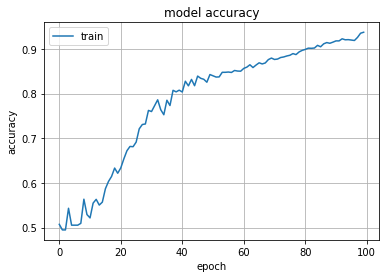

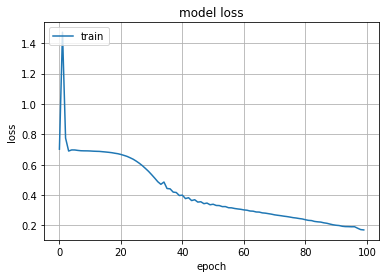

Evaluating...
Final Stats:
Accuracy: 0.8287500143051147     Loss: 0.38329124450683594


In [13]:
accuracy = evaluate_model(trainX,trainY,testX,testY)
print("Final Stats:")
print("Accuracy: {0}     Loss: {1}".format(accuracy[1],accuracy[0]))

# Try it out!
Enter a tweet of your choice in the box below to see what our model thinks of it.

In [15]:
import import_ipynb
from CodeToEmbed import make_prediction
from ipywidgets import interact, widgets, Layout
from IPython.display import display
from keras.models import load_model

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True) 
word_vectors = model.wv

In [17]:
trained_model = load_model('model/neural_model.h5')

In [18]:
text = widgets.Text(placeholder="What's happening?", 
                    layout = Layout(width='50%',height='100px', ))
display(text)

results = ["Not Offensive", "Offensive"]
print("Results: ")

def callback(text):
    predicted_values = make_prediction(model, trained_model, word_vectors, text.value)
    max_result = max(predicted_values[0][0], predicted_values[0][1])
    result_index = 0
    if max_result == predicted_values[0][1]:
        result_index = 1
        
    print(results[result_index])
    display("{0}% , {1}%".format(predicted_values[0][0] * 100,predicted_values[0][1] * 100))

text.on_submit(callback)

Text(value='', layout=Layout(height='100px', width='50%'), placeholder="What's happening?")

Results: 


### Sources: 
Dataset: Twitter Sentiment Analysis Detecting hatred tweets, provided by Analytics Vidhya
https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
 
Zhang, Z., Robinson, D. and Tepper, J. (2018) Detecting hate speech on Twitter using a convolution-GRU based deep neural network. In: Gangemi, A., Navigli, R., Vidal, M.E., Hitzler, P., Troncy, R., Hollink, L., Tordai, A. and Alam, M., (eds.) ESWC 2018: The semantic web. ESWC 2018, 03-07 Jun 2018, Heraklion, Greece. Lecture Notes in Computer Science, 10843 . Springer Verlag, pp. 745-760. ISBN 978-3-319-93417-4